In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
from torchvision import datasets

from typing import Any
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
data_folder = '../../data/FMNIST/'
fmnist = datasets.FashionMNIST(data_folder, train=True, download=True)

tr_images = fmnist.data
tr_targets = fmnist.targets

In [3]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y) -> None:
        super().__init__()
        x = x.float()/255   # scaled the input value to be between 0 & 1, dividing it by highest possible value
        x = x.view(-1, 28*28)
        self.x, self.y = x, y
    def __getitem__(self, index) -> Any:
        return self.x[index].to(device), self.y[index].to(device)
    def __len__(self) -> int:
        return len(self.x)

In [4]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

def train_batch(x, y, model, loss_fn, optimizer):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

# @torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_current = argmaxes == y
    return is_current.cpu().numpy().tolist()

In [5]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()
losses, accuracies = [], []
for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [],[]
    for ix, batch in enumerate(trn_dl):
        x, y = batch
        batch_loss = train_batch(x, y, model, loss_fn, optimizer)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(trn_dl):
        x, y = batch
        batch_accuracy = accuracy(x, y, model)
        epoch_accuracies.extend(batch_accuracy)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2
3
4


C:\Users\yashl\AppData\Local\Temp\ipykernel_23240\259570074.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{round(x*100)}%' for x in plt.gca().get_yticks()])


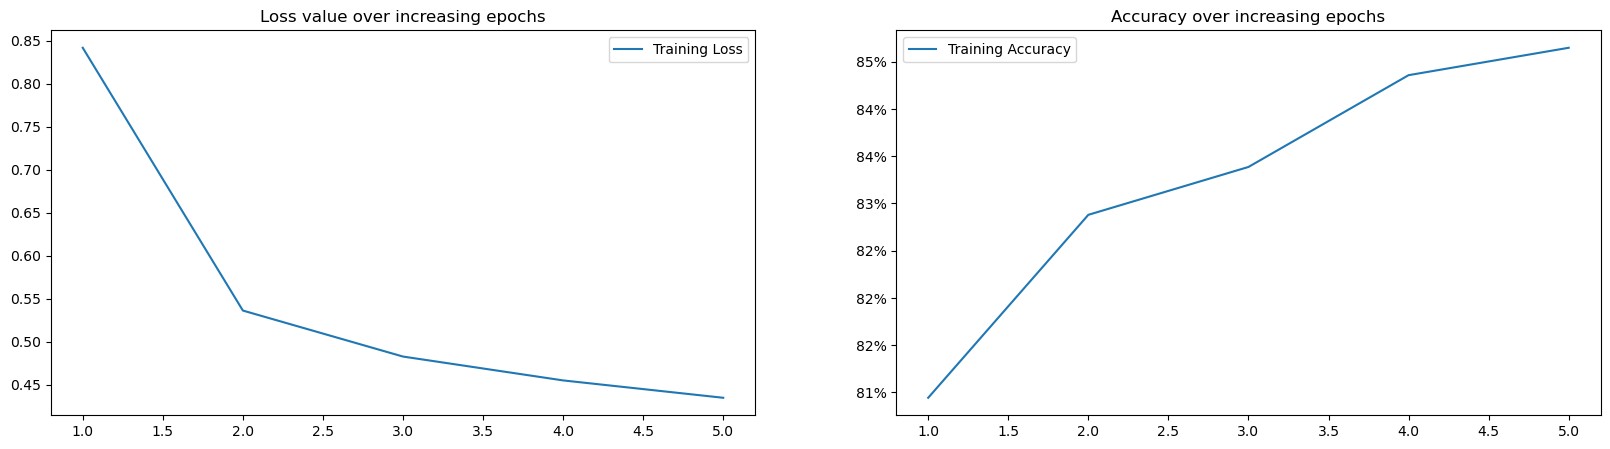

In [6]:
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(epochs, losses, label='Training Loss')
plt.title("Loss value over increasing epochs")
plt.legend()
plt.subplot(122)
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.title('Accuracy over increasing epochs')
plt.legend()
plt.gca().set_yticklabels([f'{round(x*100)}%' for x in plt.gca().get_yticks()])
plt.show()